Idea: Extend LTH to feature selection - Pruning + gradient descent for feature selection

Result:

With 70% of features remaining, we are able to get better accuracy and training time

The red pixels are the features that are ignored in the final feature subset

And this feature subset extends across neural networks. One important limitation of the original LTH paper is that it only works with same random weights. Literature later identified supermasks that, when applied to new random weights, do better than random, but is not nearly comparable to original performance. 

By applying the same pruning technique to feature selection, however, we find that unlike LTH for NN parameters, the feature subset is elastic, i.e., it is able to extend even to new random weights

----> nvm, it does better than randomly just destorying 50% of the weights, but barely better. So for MNIST in general, if you remove 50% of the pixels you can do decent, this is just confirming that and is not anythiing special.

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [3]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


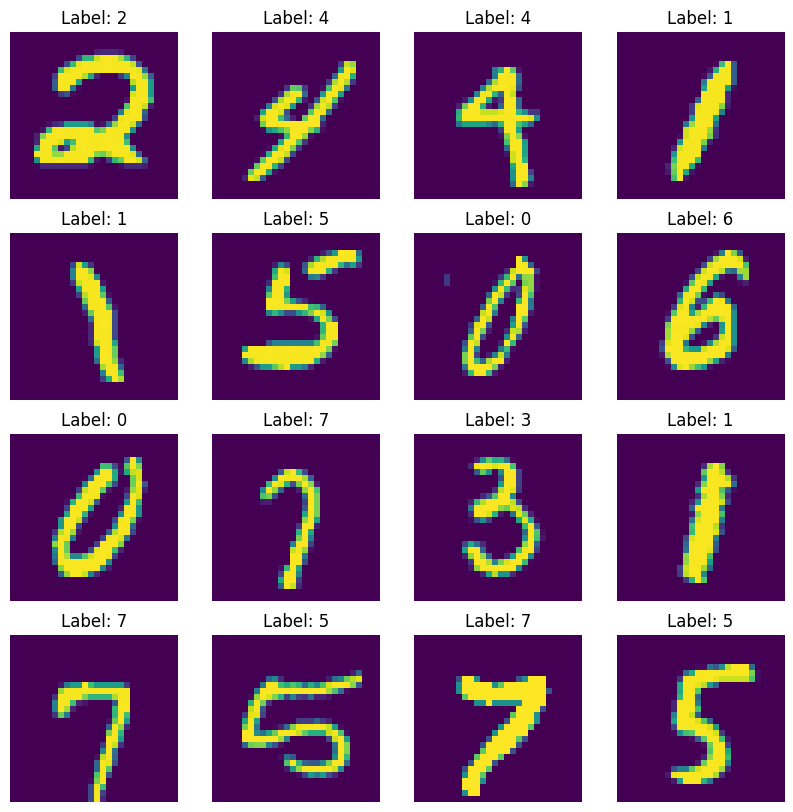

In [4]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [5]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2, mult = params

    x = x @ torch.diag(mult[0])
    # x = torch.relu(x)
    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x

# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)
mult = torch.zeros((1, 28 * 28), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2, mult])
# Mult is a diagonal matrix

In [6]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-0.3963, -1.8069, -1.1913, -0.1674,  1.3954],
        [-0.4095, -1.2080,  0.4655,  0.6705,  0.4338],
        [ 0.5353,  0.1354, -0.7000, -0.9988, -0.2636]], requires_grad=True)

In [7]:
def check_accuracy(loader, model_fn, params, verbose=False):
    split = 'val' if loader.dataset.train else 'test'
    
    if verbose:
        print('Checking accuracy on the %s set' % split)
    
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        if verbose:
            print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [8]:
def train(model_fn, params, learning_rate, print_every=100, verbose = True):
    w1, w2, mult, m1, m2, m3 = params 
    
    for t, (x, y) in enumerate(loader_train):
        
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            mult *= m3
            
        scores = model_fn(x, [w1, w2, mult])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad
            mult -= learning_rate * mult.grad

            w1.grad.zero_()
            w2.grad.zero_()
            mult.grad.zero_()

        if t % print_every == 0 and verbose:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            mult *= m3
        
    res = check_accuracy(loader_val, model_fn, [w1, w2, mult], True)
    
    return res

Iteration 0, loss = 2.6576
Checking accuracy on the val set
Got 8733 / 10000 correct (87.33%)
Iteration 0, loss = 0.4523
Checking accuracy on the val set
Got 8942 / 10000 correct (89.42%)
Iteration 0, loss = 0.5119
Checking accuracy on the val set
Got 9050 / 10000 correct (90.50%)
Iteration 0, loss = 0.3715
Checking accuracy on the val set
Got 9104 / 10000 correct (91.04%)
Iteration 0, loss = 0.4025
Checking accuracy on the val set
Got 9143 / 10000 correct (91.43%)
tensor([[ 1.2096,  0.3179,  0.1315, -0.2442,  2.9463,  0.8682,  0.5468,  0.2446,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.1162,  0.7300,  0.1974,  0.1917, -1.0856, -0.1272, -0.2379,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
         -0.2244, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

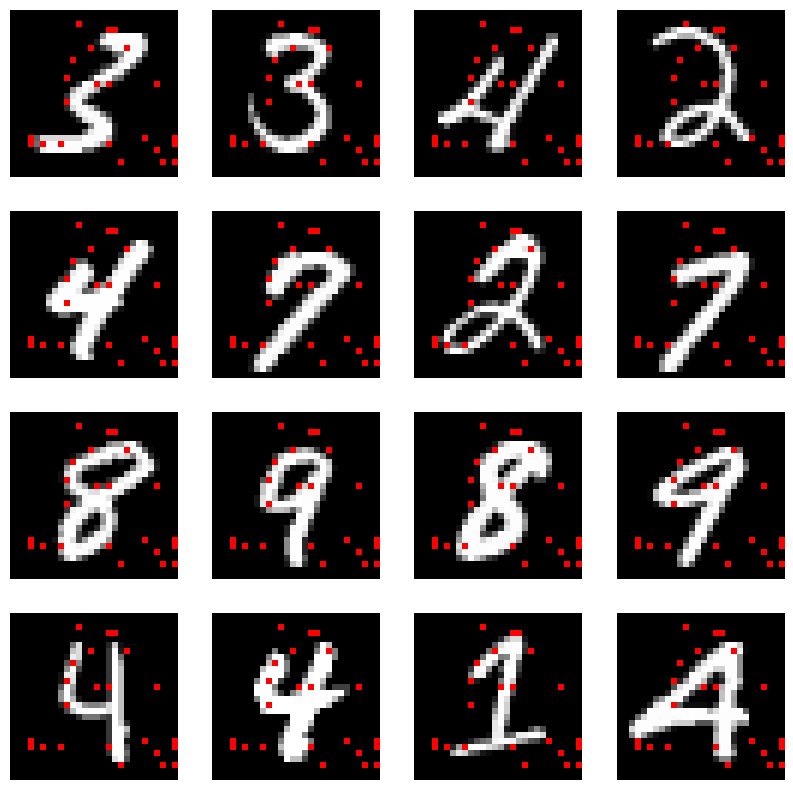

Iteration 0, loss = 2.5444
Checking accuracy on the val set
Got 8735 / 10000 correct (87.35%)
Iteration 0, loss = 0.7098
Checking accuracy on the val set
Got 8959 / 10000 correct (89.59%)
Iteration 0, loss = 0.3938
Checking accuracy on the val set
Got 9023 / 10000 correct (90.23%)
Iteration 0, loss = 0.2734
Checking accuracy on the val set
Got 9118 / 10000 correct (91.18%)
Iteration 0, loss = 0.3727
Checking accuracy on the val set
Got 9158 / 10000 correct (91.58%)
tensor([[ 1.2096,  0.3179,  0.1315, -0.2442,  2.9463,  0.8682,  0.5468,  0.2446,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.1162,  0.7300,  0.1974,  0.1917, -1.0856, -0.1272, -0.2379,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
         -0.2243, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

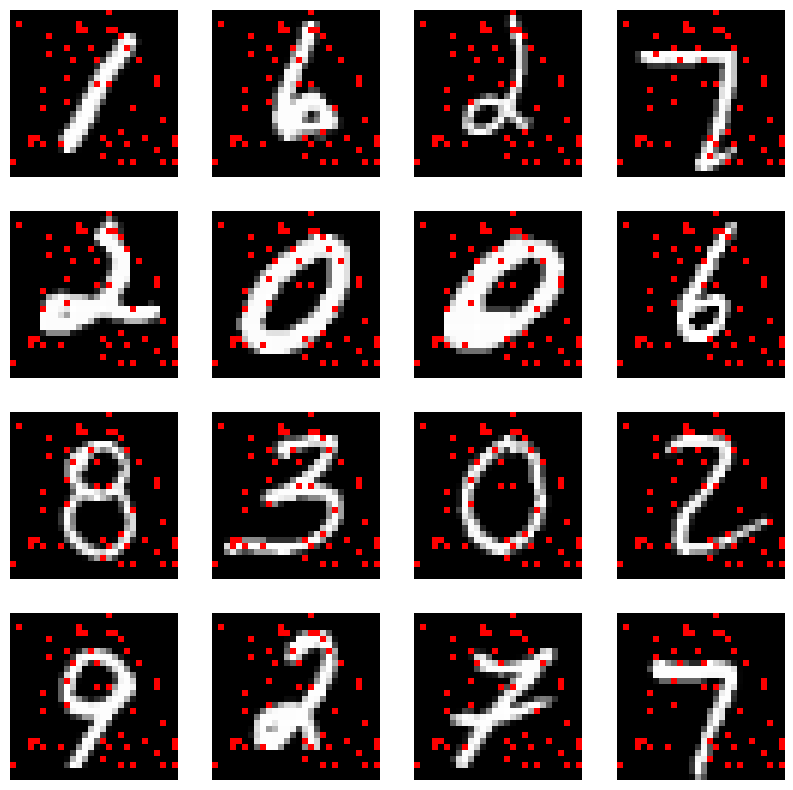

Iteration 0, loss = 2.4460
Checking accuracy on the val set
Got 8734 / 10000 correct (87.34%)
Iteration 0, loss = 0.5993
Checking accuracy on the val set
Got 8995 / 10000 correct (89.95%)
Iteration 0, loss = 0.4371
Checking accuracy on the val set
Got 9050 / 10000 correct (90.50%)
Iteration 0, loss = 0.4876
Checking accuracy on the val set
Got 9110 / 10000 correct (91.10%)
Iteration 0, loss = 0.3219
Checking accuracy on the val set
Got 9151 / 10000 correct (91.51%)
tensor([[ 1.2096,  0.3179,  0.1315, -0.2442,  2.9463,  0.8682,  0.5468,  0.2446,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.1974,  0.1917, -1.0856, -0.0000, -0.2379,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1374,
         -0.2243, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

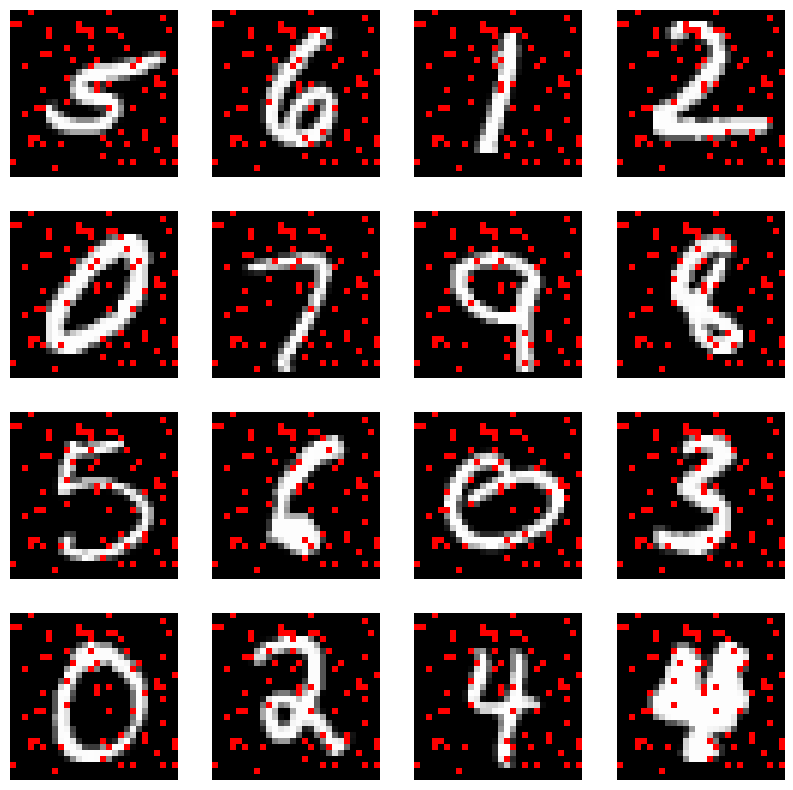

Iteration 0, loss = 2.4743
Checking accuracy on the val set
Got 8719 / 10000 correct (87.19%)
Iteration 0, loss = 0.5447
Checking accuracy on the val set
Got 8946 / 10000 correct (89.46%)
Iteration 0, loss = 0.3427
Checking accuracy on the val set
Got 9043 / 10000 correct (90.43%)
Iteration 0, loss = 0.3190
Checking accuracy on the val set
Got 9103 / 10000 correct (91.03%)
Iteration 0, loss = 0.2418
Checking accuracy on the val set
Got 9130 / 10000 correct (91.30%)
tensor([[ 1.2096,  0.3179,  0.0000, -0.2442,  2.9463,  0.8682,  0.5468,  0.2446,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.1974,  0.1917, -1.0856, -0.0000, -0.2379,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1374,
         -0.2243, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

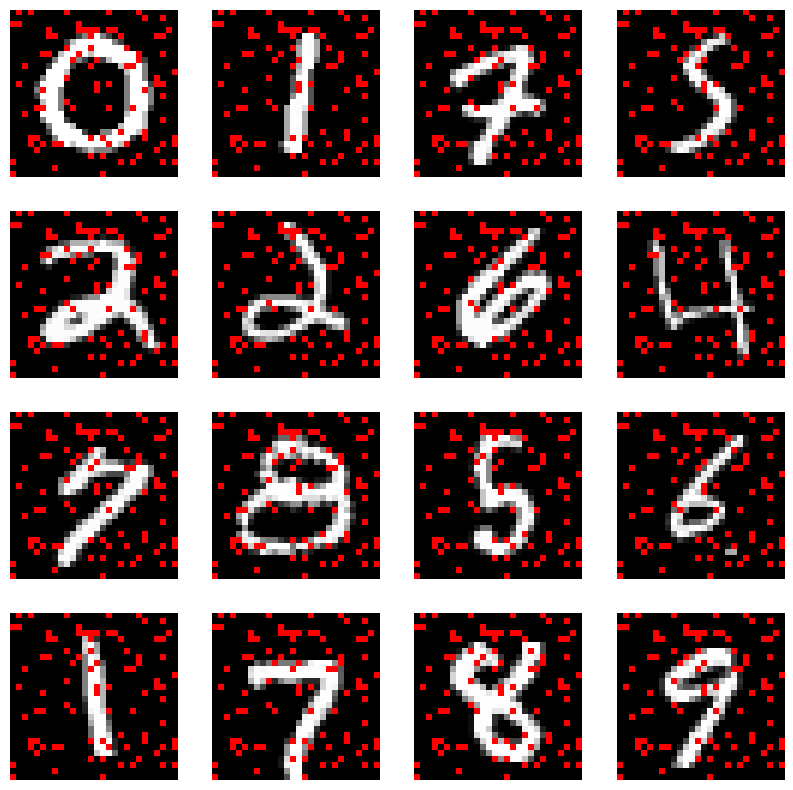

Iteration 0, loss = 2.4195
Checking accuracy on the val set
Got 8753 / 10000 correct (87.53%)
Iteration 0, loss = 0.6407
Checking accuracy on the val set
Got 8992 / 10000 correct (89.92%)
Iteration 0, loss = 0.5702
Checking accuracy on the val set
Got 9049 / 10000 correct (90.49%)
Iteration 0, loss = 0.3593
Checking accuracy on the val set
Got 9116 / 10000 correct (91.16%)
Iteration 0, loss = 0.3248
Checking accuracy on the val set
Got 9150 / 10000 correct (91.50%)
tensor([[ 1.2096,  0.3179,  0.0000, -0.2442,  2.9463,  0.8682,  0.5468,  0.2446,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.2379,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9949,  0.5281,  0.4943, -2.1374,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

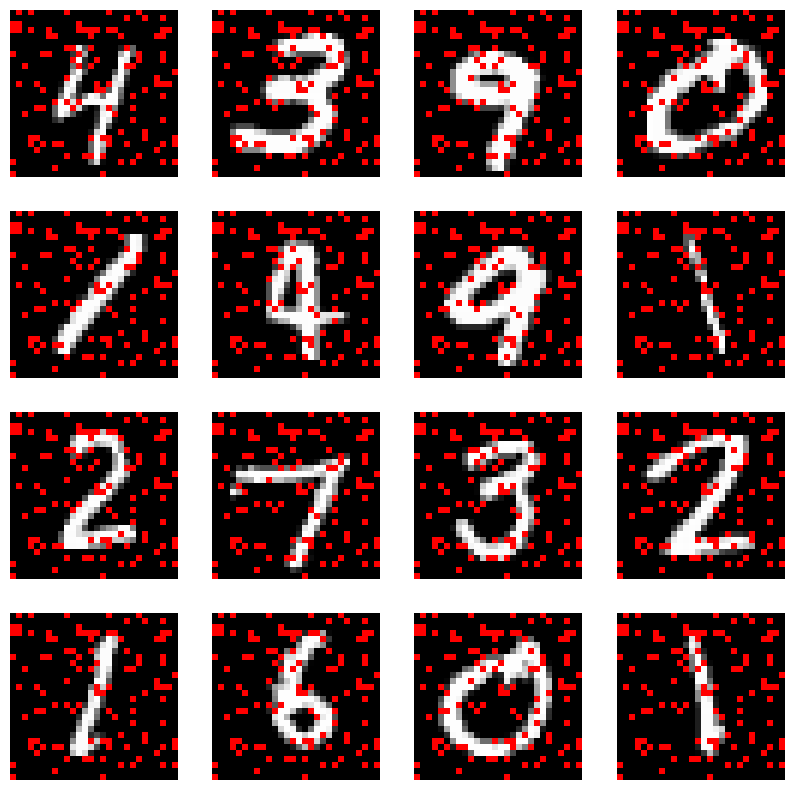

Iteration 0, loss = 2.4768
Checking accuracy on the val set
Got 8751 / 10000 correct (87.51%)
Iteration 0, loss = 0.6343
Checking accuracy on the val set
Got 8960 / 10000 correct (89.60%)
Iteration 0, loss = 0.4001
Checking accuracy on the val set
Got 9041 / 10000 correct (90.41%)
Iteration 0, loss = 0.3999
Checking accuracy on the val set
Got 9104 / 10000 correct (91.04%)
Iteration 0, loss = 0.1443
Checking accuracy on the val set
Got 9131 / 10000 correct (91.31%)
tensor([[ 1.2096,  0.3179,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

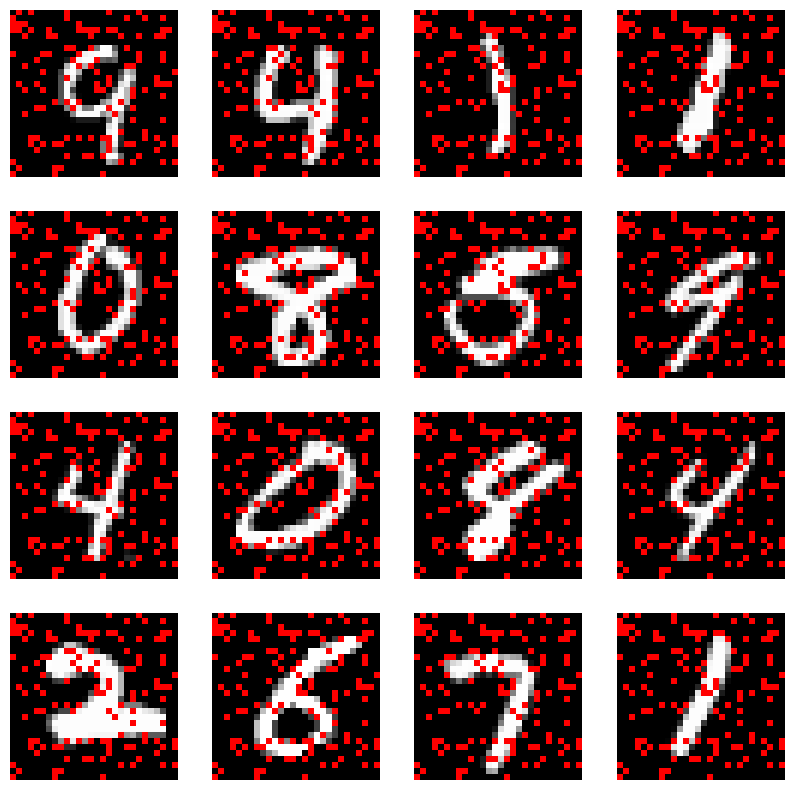

Iteration 0, loss = 2.5811
Checking accuracy on the val set
Got 8757 / 10000 correct (87.57%)
Iteration 0, loss = 0.5451
Checking accuracy on the val set
Got 8974 / 10000 correct (89.74%)
Iteration 0, loss = 0.4520
Checking accuracy on the val set
Got 9056 / 10000 correct (90.56%)
Iteration 0, loss = 0.2319
Checking accuracy on the val set
Got 9122 / 10000 correct (91.22%)
Iteration 0, loss = 0.2923
Checking accuracy on the val set
Got 9145 / 10000 correct (91.45%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331,  0.3503, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

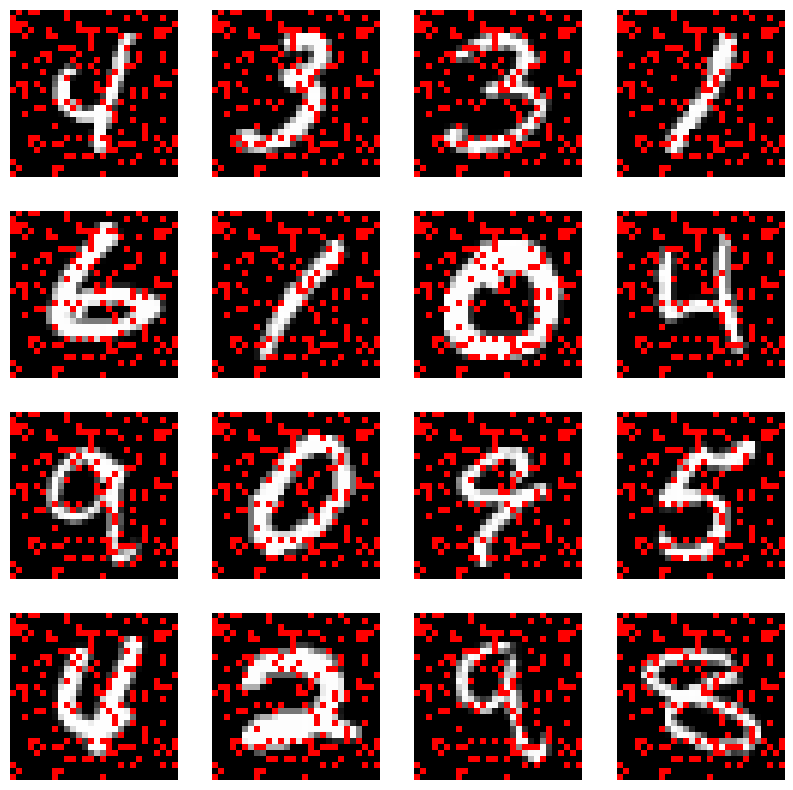

Iteration 0, loss = 2.3937
Checking accuracy on the val set
Got 8738 / 10000 correct (87.38%)
Iteration 0, loss = 0.4581
Checking accuracy on the val set
Got 8960 / 10000 correct (89.60%)
Iteration 0, loss = 0.4148
Checking accuracy on the val set
Got 9036 / 10000 correct (90.36%)
Iteration 0, loss = 0.3629
Checking accuracy on the val set
Got 9092 / 10000 correct (90.92%)
Iteration 0, loss = 0.3026
Checking accuracy on the val set
Got 9130 / 10000 correct (91.30%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.3905,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

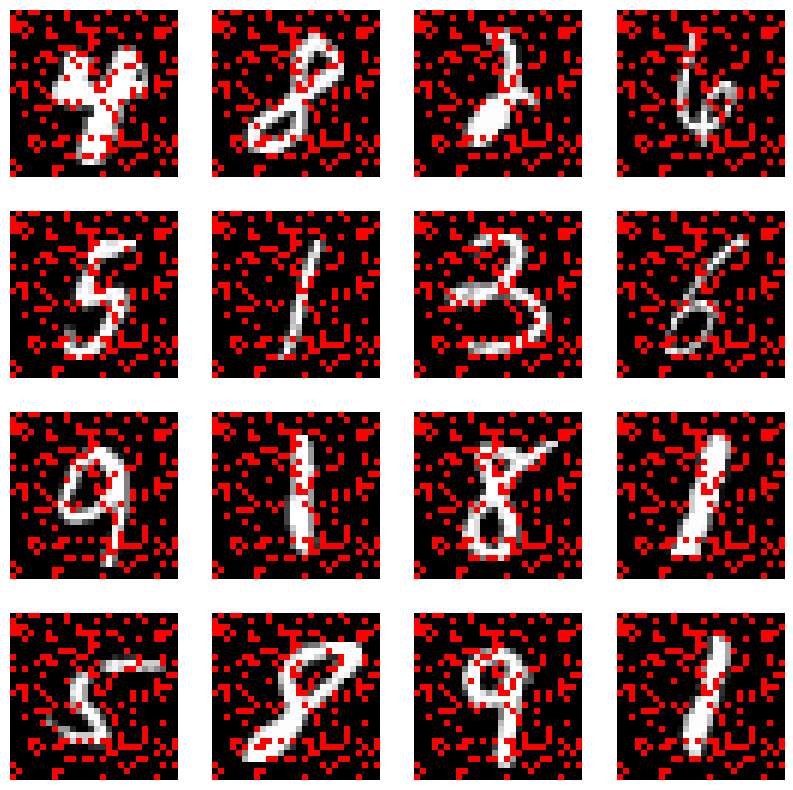

Iteration 0, loss = 2.3906
Checking accuracy on the val set
Got 8743 / 10000 correct (87.43%)
Iteration 0, loss = 0.5392
Checking accuracy on the val set
Got 8966 / 10000 correct (89.66%)
Iteration 0, loss = 0.4575
Checking accuracy on the val set
Got 9044 / 10000 correct (90.44%)
Iteration 0, loss = 0.3193
Checking accuracy on the val set
Got 9102 / 10000 correct (91.02%)
Iteration 0, loss = 0.2631
Checking accuracy on the val set
Got 9142 / 10000 correct (91.42%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

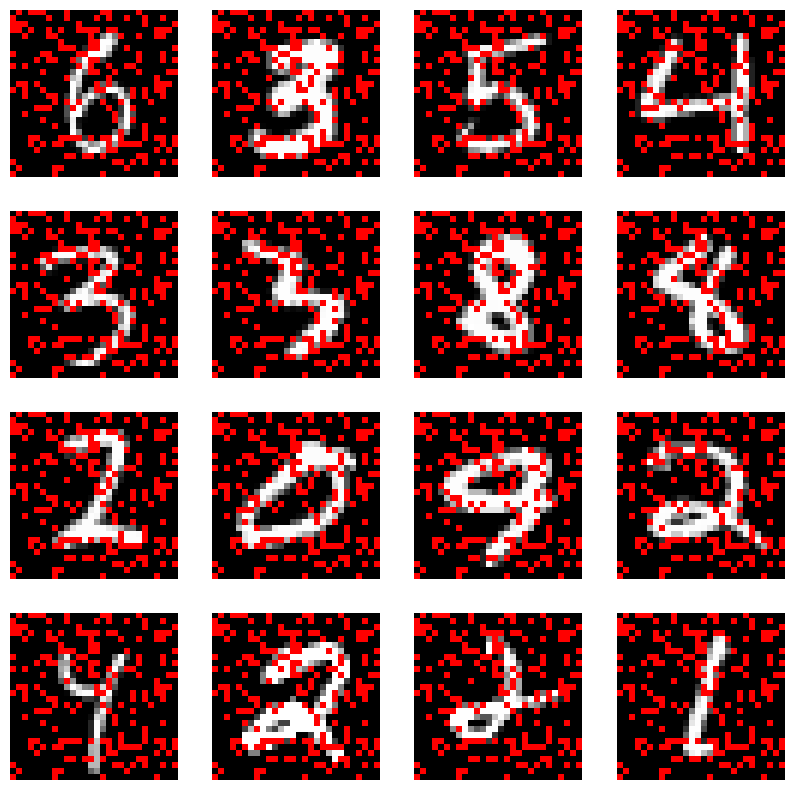

Iteration 0, loss = 2.4157
Checking accuracy on the val set
Got 8741 / 10000 correct (87.41%)
Iteration 0, loss = 0.4901
Checking accuracy on the val set
Got 8945 / 10000 correct (89.45%)
Iteration 0, loss = 0.4058
Checking accuracy on the val set
Got 9034 / 10000 correct (90.34%)
Iteration 0, loss = 0.4026
Checking accuracy on the val set
Got 9084 / 10000 correct (90.84%)
Iteration 0, loss = 0.3681
Checking accuracy on the val set
Got 9140 / 10000 correct (91.40%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.4943, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.4864, -1.5556,

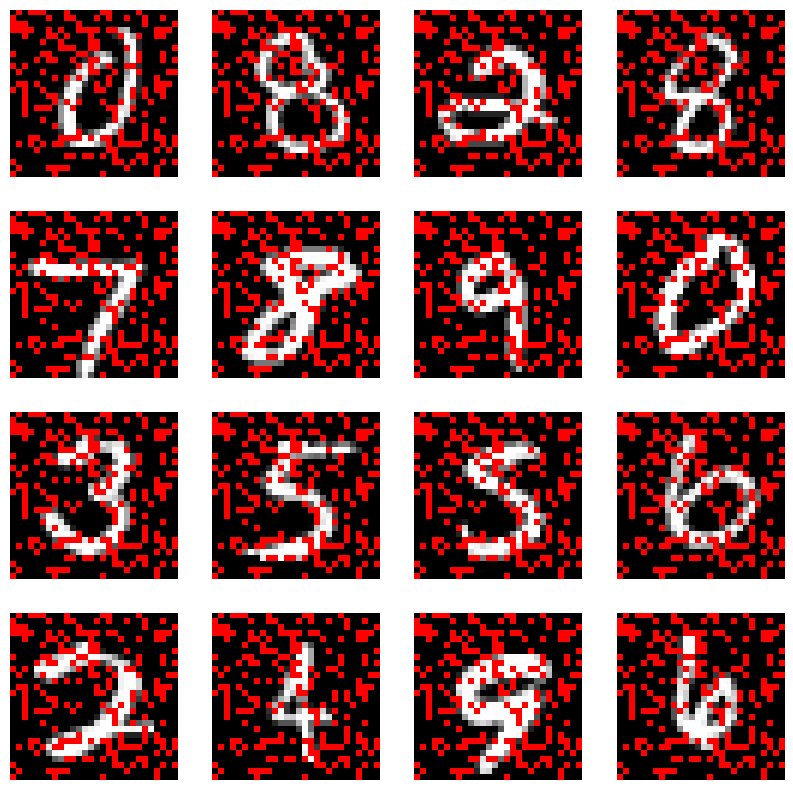

Iteration 0, loss = 2.4194
Checking accuracy on the val set
Got 8758 / 10000 correct (87.58%)
Iteration 0, loss = 0.5866
Checking accuracy on the val set
Got 8969 / 10000 correct (89.69%)
Iteration 0, loss = 0.3346
Checking accuracy on the val set
Got 9015 / 10000 correct (90.15%)
Iteration 0, loss = 0.3902
Checking accuracy on the val set
Got 9100 / 10000 correct (91.00%)
Iteration 0, loss = 0.3260
Checking accuracy on the val set
Got 9129 / 10000 correct (91.29%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

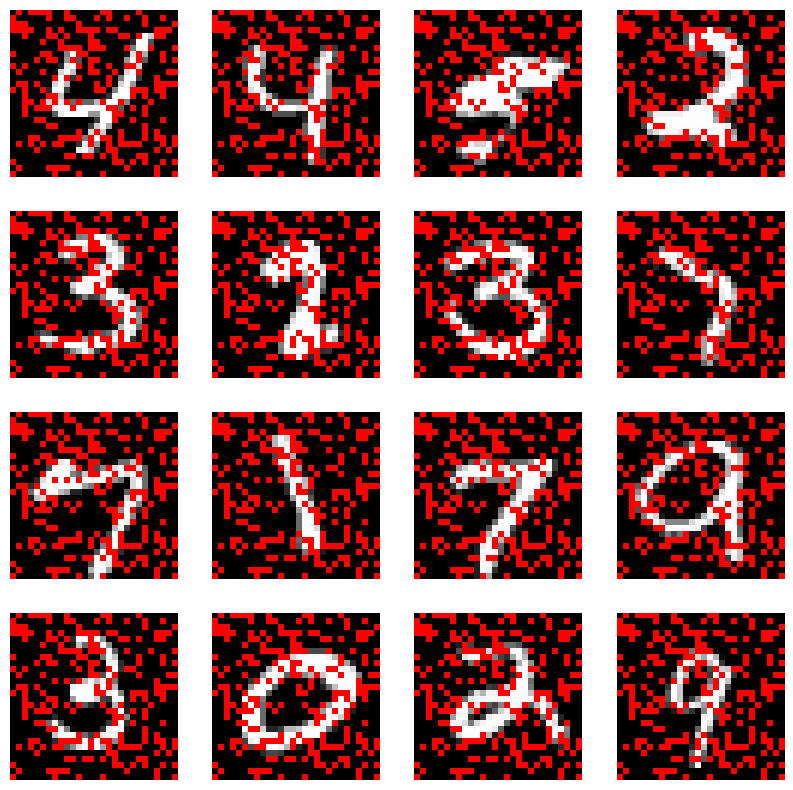

Iteration 0, loss = 2.4199
Checking accuracy on the val set
Got 8746 / 10000 correct (87.46%)
Iteration 0, loss = 0.5152
Checking accuracy on the val set
Got 8962 / 10000 correct (89.62%)
Iteration 0, loss = 0.3995
Checking accuracy on the val set
Got 9053 / 10000 correct (90.53%)
Iteration 0, loss = 0.3126
Checking accuracy on the val set
Got 9115 / 10000 correct (91.15%)
Iteration 0, loss = 0.4223
Checking accuracy on the val set
Got 9163 / 10000 correct (91.63%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.5468,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.5281,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

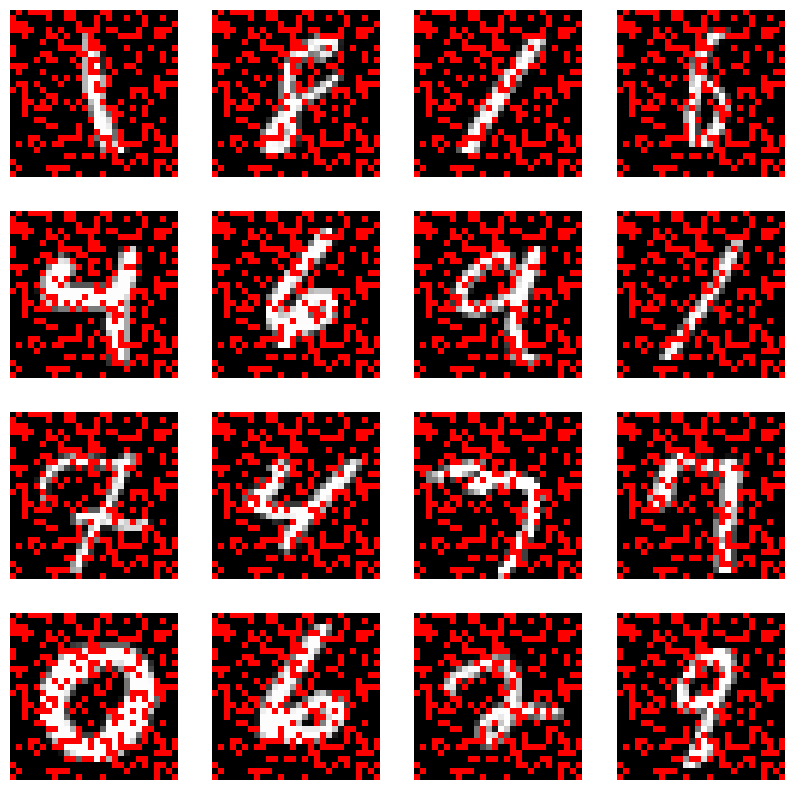

Iteration 0, loss = 2.4258
Checking accuracy on the val set
Got 8763 / 10000 correct (87.63%)
Iteration 0, loss = 0.4522
Checking accuracy on the val set
Got 8990 / 10000 correct (89.90%)
Iteration 0, loss = 0.2979
Checking accuracy on the val set
Got 9059 / 10000 correct (90.59%)
Iteration 0, loss = 0.3756
Checking accuracy on the val set
Got 9122 / 10000 correct (91.22%)
Iteration 0, loss = 0.2884
Checking accuracy on the val set
Got 9148 / 10000 correct (91.48%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950,  0.0000,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

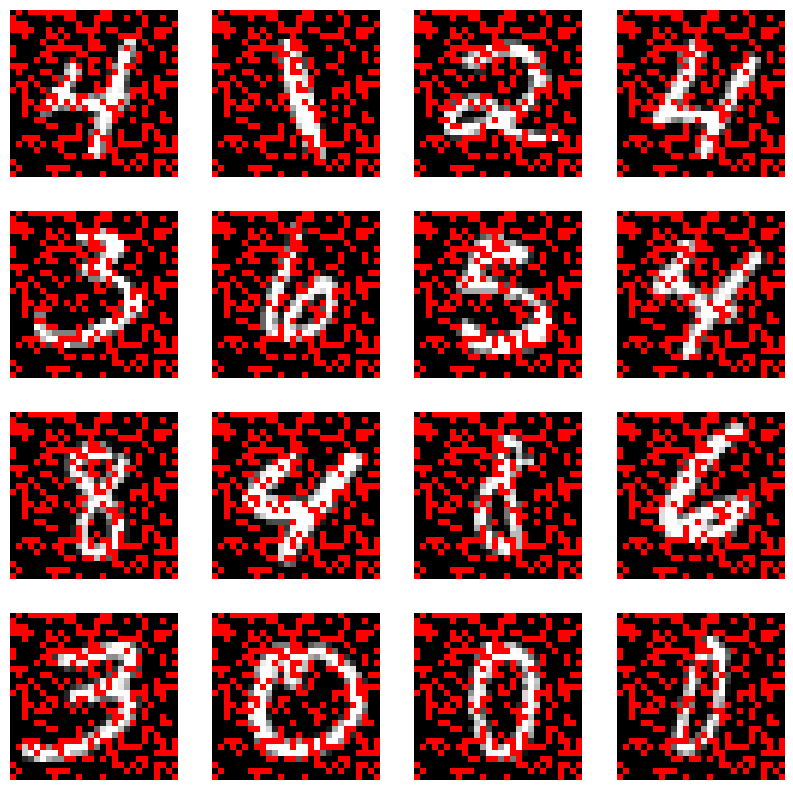

Iteration 0, loss = 2.3824
Checking accuracy on the val set
Got 8748 / 10000 correct (87.48%)
Iteration 0, loss = 0.5158
Checking accuracy on the val set
Got 8979 / 10000 correct (89.79%)
Iteration 0, loss = 0.5270
Checking accuracy on the val set
Got 9064 / 10000 correct (90.64%)
Iteration 0, loss = 0.4432
Checking accuracy on the val set
Got 9110 / 10000 correct (91.10%)
Iteration 0, loss = 0.3331
Checking accuracy on the val set
Got 9147 / 10000 correct (91.47%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3948, -3.1998, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

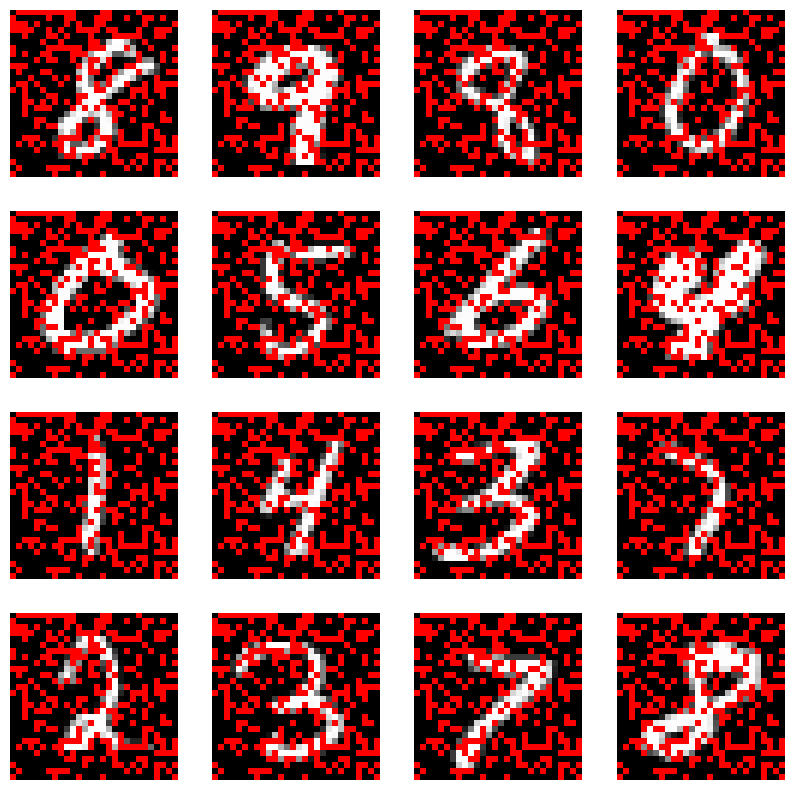

Iteration 0, loss = 2.4076
Checking accuracy on the val set
Got 8673 / 10000 correct (86.73%)
Iteration 0, loss = 0.5503
Checking accuracy on the val set
Got 8968 / 10000 correct (89.68%)
Iteration 0, loss = 0.3533
Checking accuracy on the val set
Got 9038 / 10000 correct (90.38%)
Iteration 0, loss = 0.3725
Checking accuracy on the val set
Got 9102 / 10000 correct (91.02%)
Iteration 0, loss = 0.4323
Checking accuracy on the val set
Got 9149 / 10000 correct (91.49%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.6482, -1.9950, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

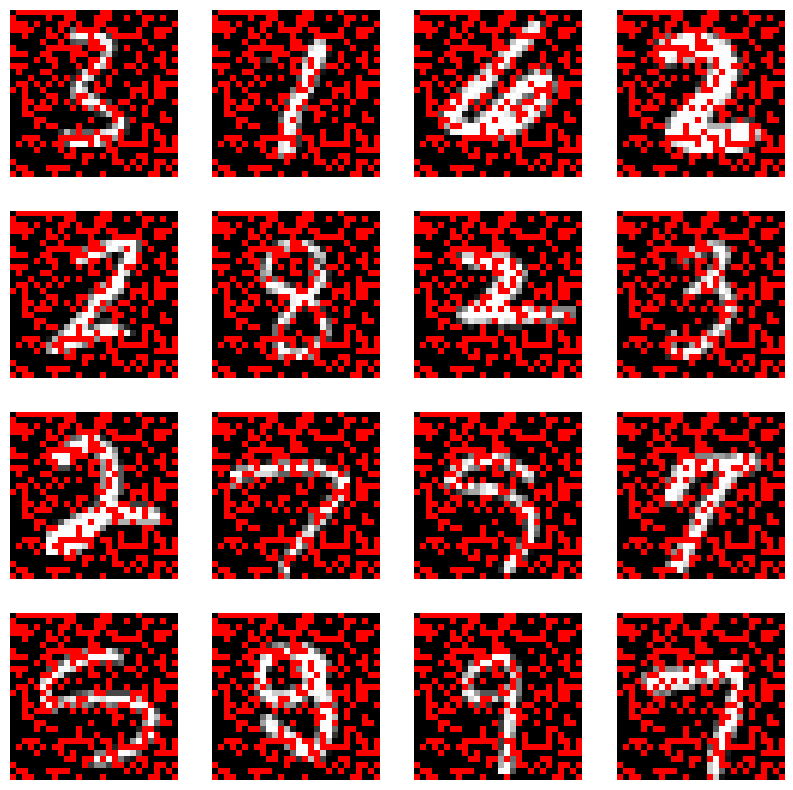

Iteration 0, loss = 2.4334
Checking accuracy on the val set
Got 8725 / 10000 correct (87.25%)
Iteration 0, loss = 0.5293
Checking accuracy on the val set
Got 8934 / 10000 correct (89.34%)
Iteration 0, loss = 0.5077
Checking accuracy on the val set
Got 9058 / 10000 correct (90.58%)
Iteration 0, loss = 0.2624
Checking accuracy on the val set
Got 9098 / 10000 correct (90.98%)
Iteration 0, loss = 0.1596
Checking accuracy on the val set
Got 9156 / 10000 correct (91.56%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747,  0.0000, -1.9950,  0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

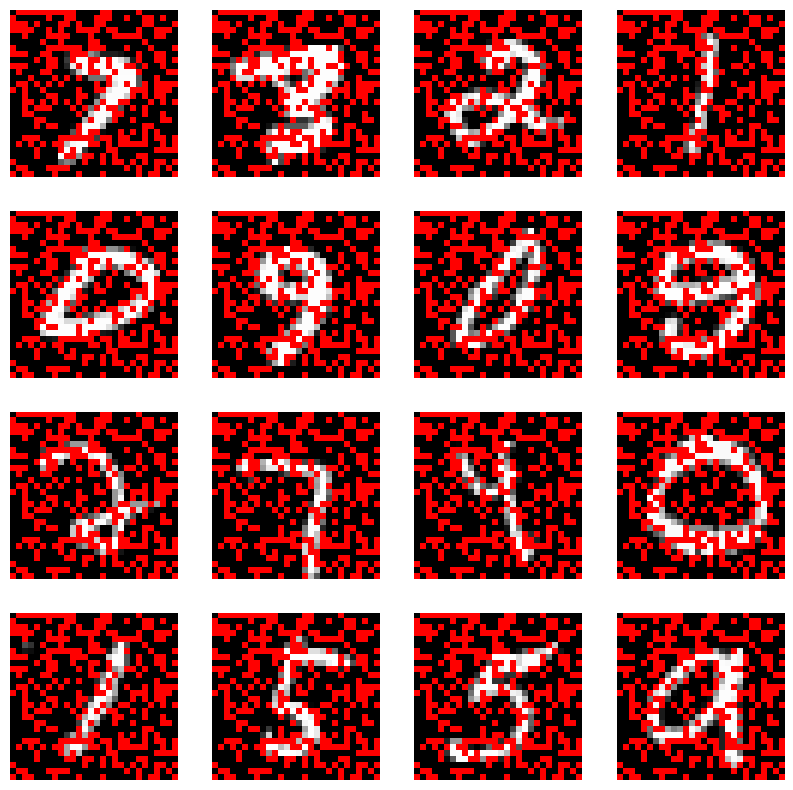

Iteration 0, loss = 2.5233
Checking accuracy on the val set
Got 8750 / 10000 correct (87.50%)
Iteration 0, loss = 0.5474
Checking accuracy on the val set
Got 8932 / 10000 correct (89.32%)
Iteration 0, loss = 0.4209
Checking accuracy on the val set
Got 9052 / 10000 correct (90.52%)
Iteration 0, loss = 0.2563
Checking accuracy on the val set
Got 9090 / 10000 correct (90.90%)
Iteration 0, loss = 0.4344
Checking accuracy on the val set
Got 9118 / 10000 correct (91.18%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.7300,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747, -0.0000, -1.9949,  0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

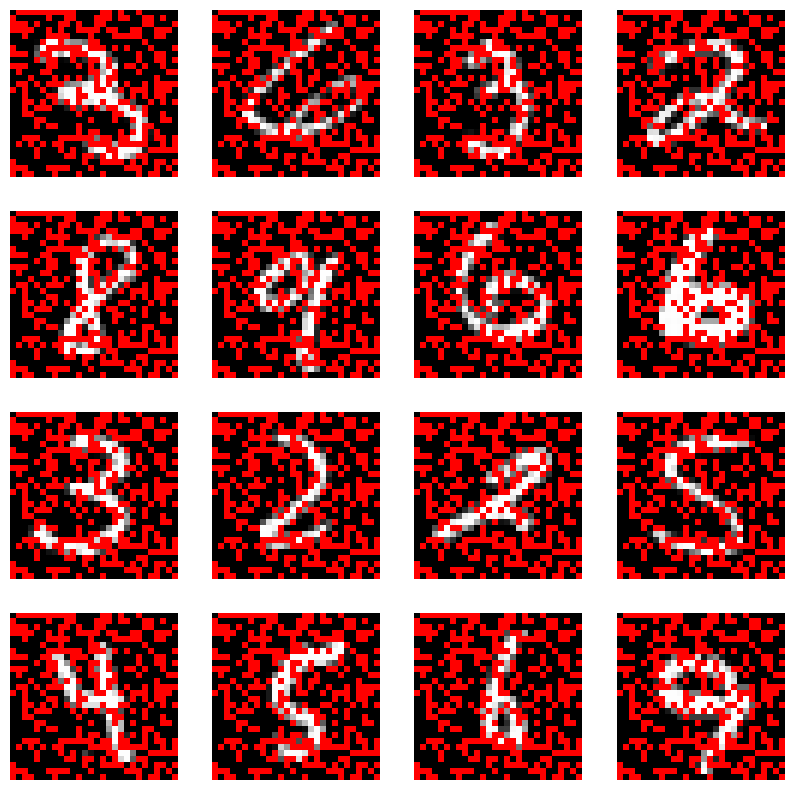

Iteration 0, loss = 2.4077
Checking accuracy on the val set
Got 8729 / 10000 correct (87.29%)
Iteration 0, loss = 0.4453
Checking accuracy on the val set
Got 8947 / 10000 correct (89.47%)
Iteration 0, loss = 0.5040
Checking accuracy on the val set
Got 9038 / 10000 correct (90.38%)
Iteration 0, loss = 0.3399
Checking accuracy on the val set
Got 9092 / 10000 correct (90.92%)
Iteration 0, loss = 0.3386
Checking accuracy on the val set
Got 9131 / 10000 correct (91.31%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.7659,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.7617,  0.9747,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

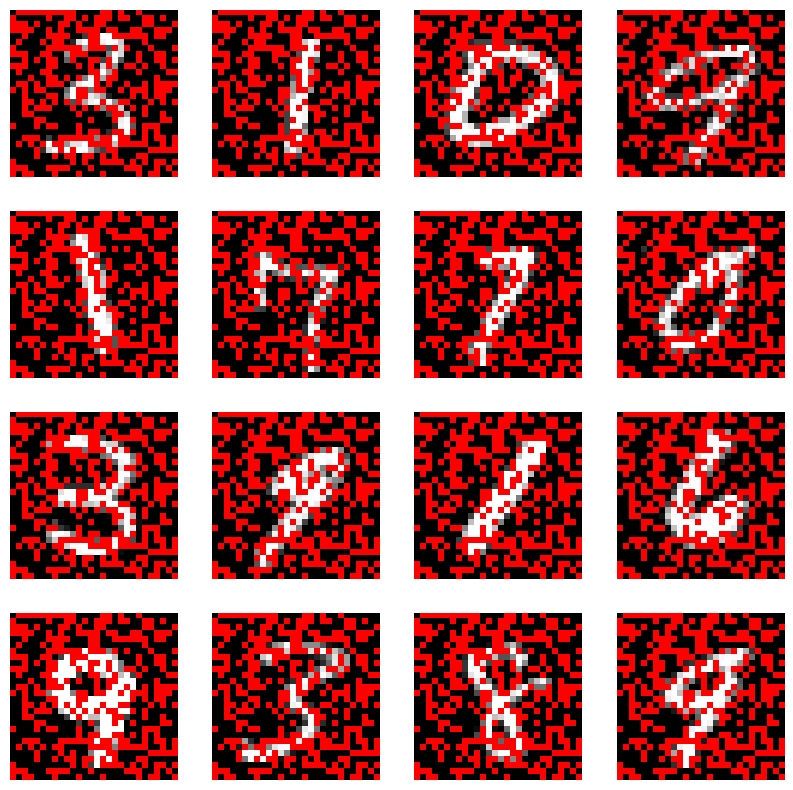

Iteration 0, loss = 2.4256
Checking accuracy on the val set
Got 8699 / 10000 correct (86.99%)
Iteration 0, loss = 0.7122
Checking accuracy on the val set
Got 8934 / 10000 correct (89.34%)
Iteration 0, loss = 0.2791
Checking accuracy on the val set
Got 9043 / 10000 correct (90.43%)
Iteration 0, loss = 0.5541
Checking accuracy on the val set
Got 9091 / 10000 correct (90.91%)
Iteration 0, loss = 0.2697
Checking accuracy on the val set
Got 9133 / 10000 correct (91.33%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

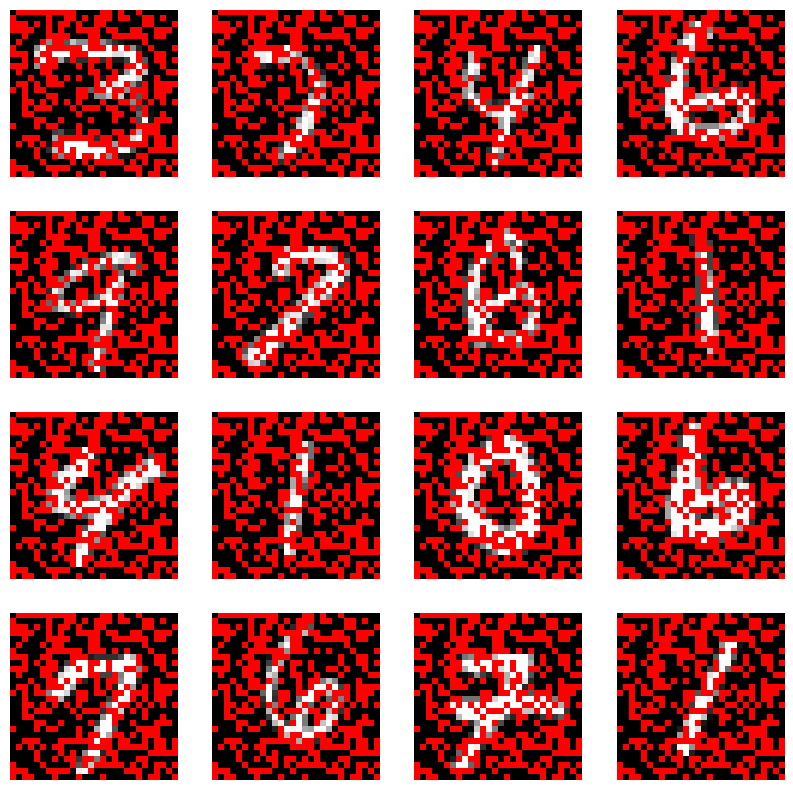

Iteration 0, loss = 2.5277
Checking accuracy on the val set
Got 8734 / 10000 correct (87.34%)
Iteration 0, loss = 0.5831
Checking accuracy on the val set
Got 8929 / 10000 correct (89.29%)
Iteration 0, loss = 0.3385
Checking accuracy on the val set
Got 9018 / 10000 correct (90.18%)
Iteration 0, loss = 0.3897
Checking accuracy on the val set
Got 9079 / 10000 correct (90.79%)
Iteration 0, loss = 0.3047
Checking accuracy on the val set
Got 9112 / 10000 correct (91.12%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

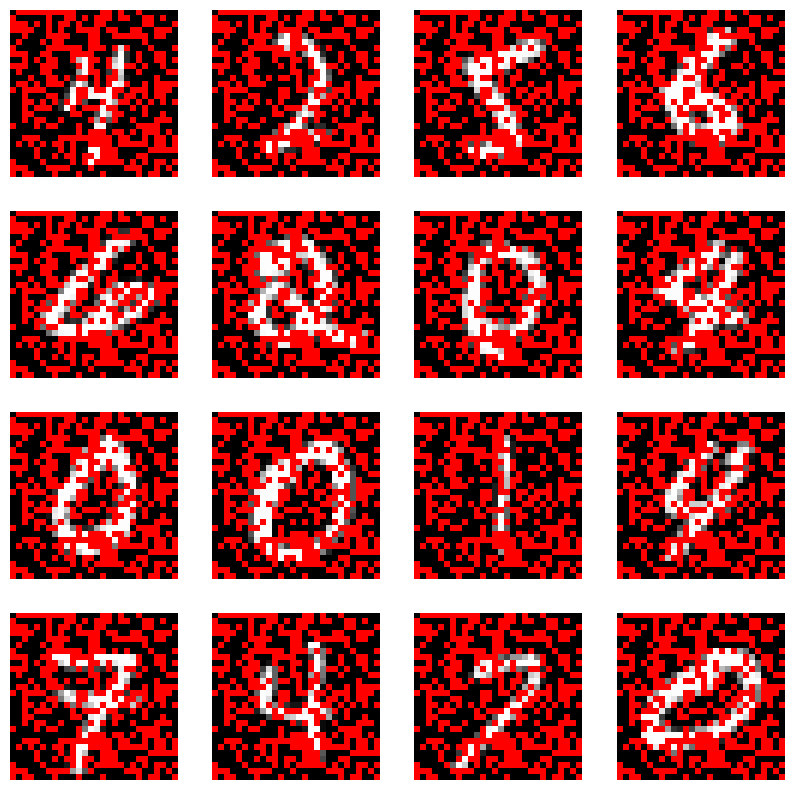

Iteration 0, loss = 2.4581
Checking accuracy on the val set
Got 8730 / 10000 correct (87.30%)
Iteration 0, loss = 0.7432
Checking accuracy on the val set
Got 8949 / 10000 correct (89.49%)
Iteration 0, loss = 0.3988
Checking accuracy on the val set
Got 9021 / 10000 correct (90.21%)
Iteration 0, loss = 0.3696
Checking accuracy on the val set
Got 9081 / 10000 correct (90.81%)
Iteration 0, loss = 0.3981
Checking accuracy on the val set
Got 9086 / 10000 correct (90.86%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.8682,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1997, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

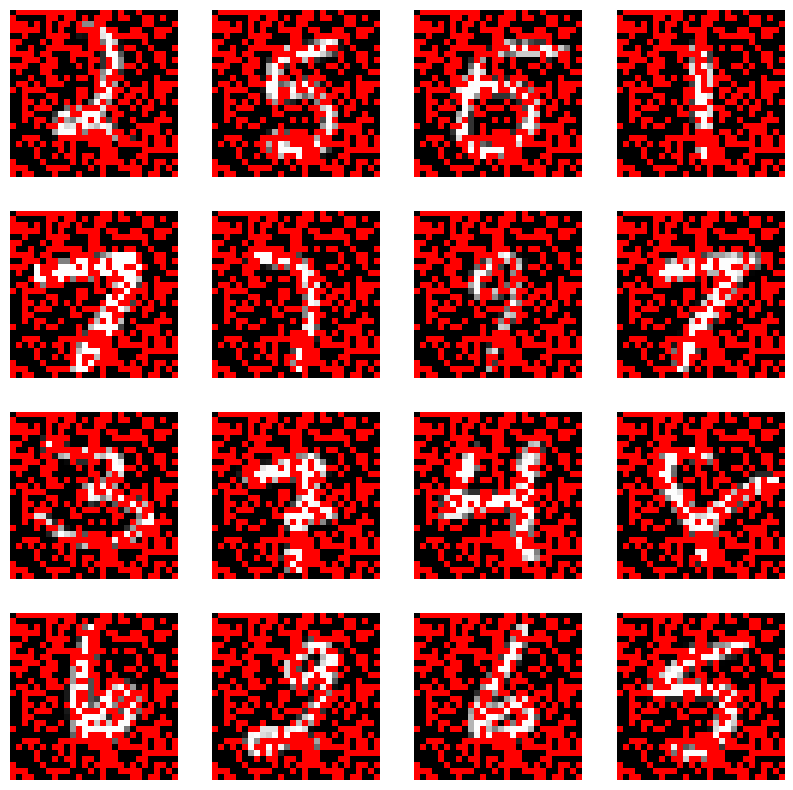

Iteration 0, loss = 2.4507
Checking accuracy on the val set
Got 8708 / 10000 correct (87.08%)
Iteration 0, loss = 0.4238
Checking accuracy on the val set
Got 8926 / 10000 correct (89.26%)
Iteration 0, loss = 0.4015
Checking accuracy on the val set
Got 9027 / 10000 correct (90.27%)
Iteration 0, loss = 0.3996
Checking accuracy on the val set
Got 9063 / 10000 correct (90.63%)
Iteration 0, loss = 0.4177
Checking accuracy on the val set
Got 9138 / 10000 correct (91.38%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747, -0.0000, -1.9949, -0.0000,  0.0000, -2.1372,
          0.0000, -3.2379,  1.3946, -3.1996, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

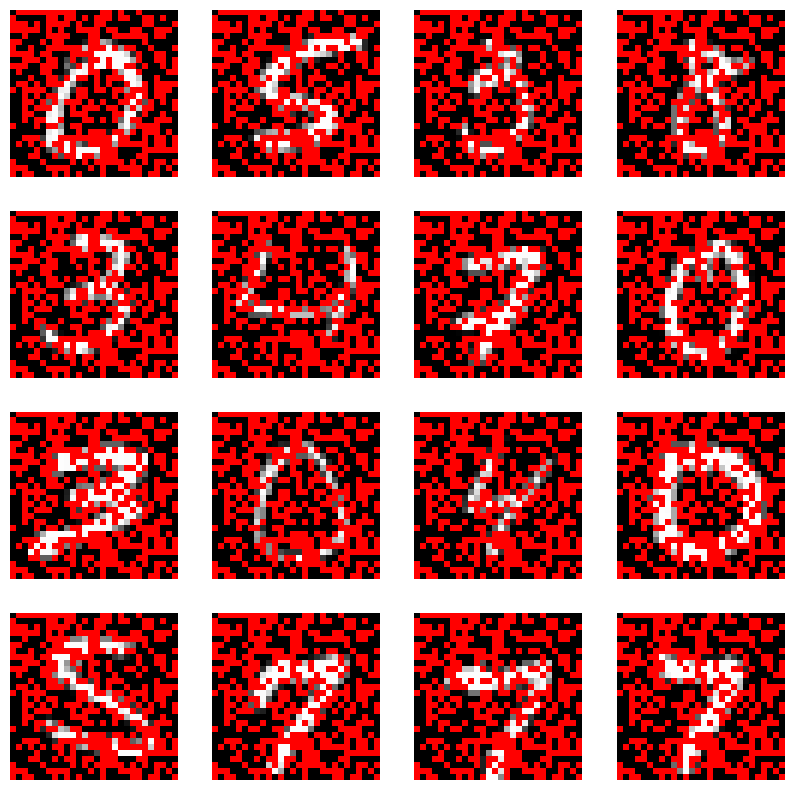

Iteration 0, loss = 2.4315
Checking accuracy on the val set
Got 8703 / 10000 correct (87.03%)
Iteration 0, loss = 0.5224
Checking accuracy on the val set
Got 8912 / 10000 correct (89.12%)
Iteration 0, loss = 0.2959
Checking accuracy on the val set
Got 9023 / 10000 correct (90.23%)
Iteration 0, loss = 0.4225
Checking accuracy on the val set
Got 9053 / 10000 correct (90.53%)
Iteration 0, loss = 0.1985
Checking accuracy on the val set
Got 9112 / 10000 correct (91.12%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747, -0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1996, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

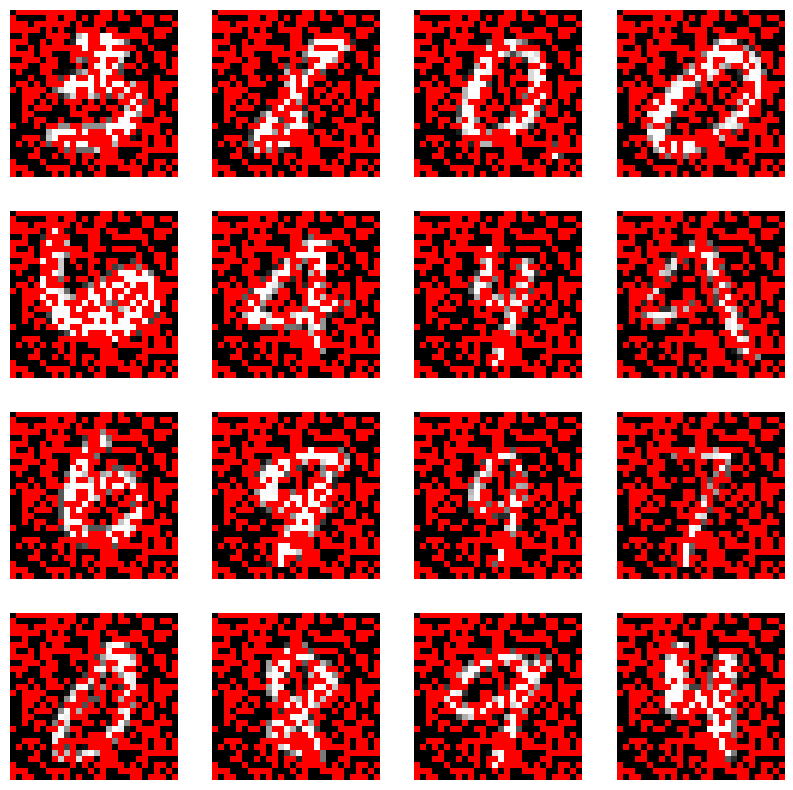

Iteration 0, loss = 2.5722
Checking accuracy on the val set
Got 8691 / 10000 correct (86.91%)
Iteration 0, loss = 0.4251
Checking accuracy on the val set
Got 8901 / 10000 correct (89.01%)
Iteration 0, loss = 0.4146
Checking accuracy on the val set
Got 9007 / 10000 correct (90.07%)
Iteration 0, loss = 0.4476
Checking accuracy on the val set
Got 9051 / 10000 correct (90.51%)
Iteration 0, loss = 0.5388
Checking accuracy on the val set
Got 9105 / 10000 correct (91.05%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.9682,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1996, -0.9733, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710, -0.0000, -1.5556,

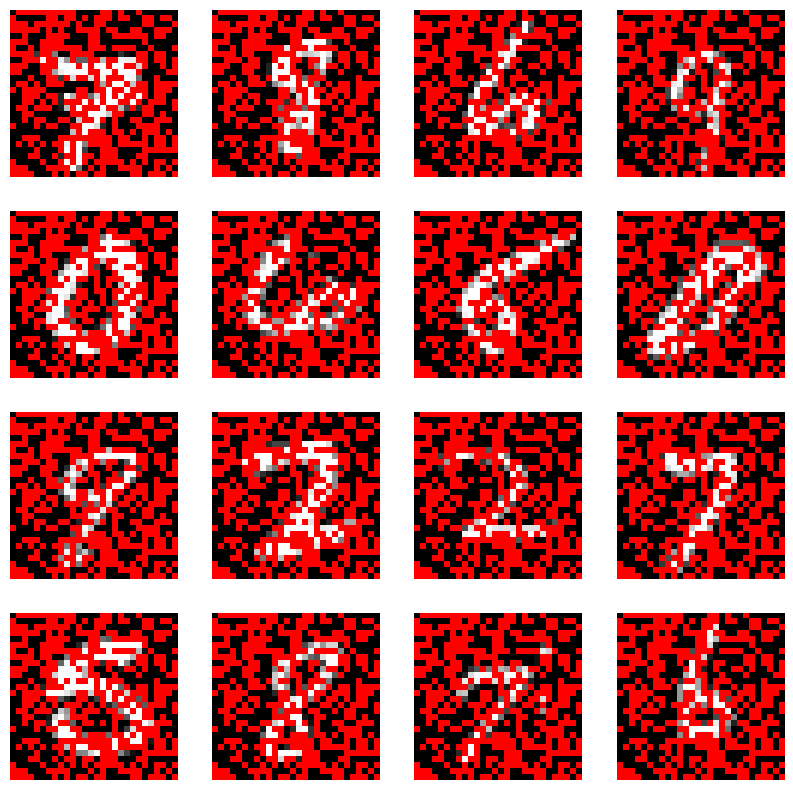

Iteration 0, loss = 2.4634
Checking accuracy on the val set
Got 8705 / 10000 correct (87.05%)
Iteration 0, loss = 0.6392
Checking accuracy on the val set
Got 8902 / 10000 correct (89.02%)
Iteration 0, loss = 0.3542
Checking accuracy on the val set
Got 9008 / 10000 correct (90.08%)
Iteration 0, loss = 0.5245
Checking accuracy on the val set
Got 9062 / 10000 correct (90.62%)
Iteration 0, loss = 0.1561
Checking accuracy on the val set
Got 9104 / 10000 correct (91.04%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.9747,  0.0000, -1.9949,  0.0000, -0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1996,  0.0000, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

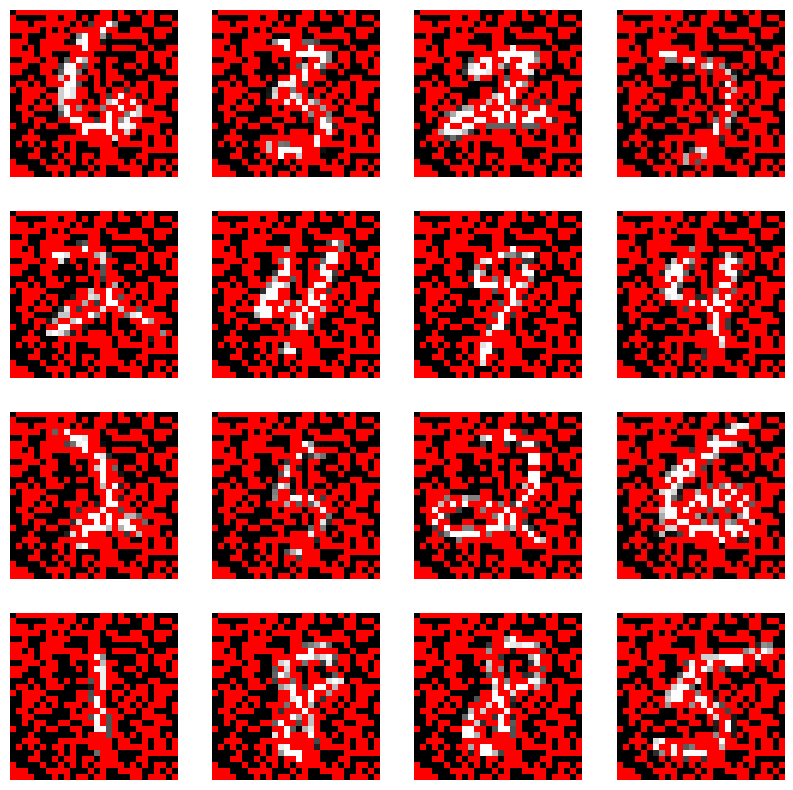

Iteration 0, loss = 2.5921
Checking accuracy on the val set
Got 8709 / 10000 correct (87.09%)
Iteration 0, loss = 0.6352
Checking accuracy on the val set
Got 8915 / 10000 correct (89.15%)
Iteration 0, loss = 0.4564
Checking accuracy on the val set
Got 9004 / 10000 correct (90.04%)
Iteration 0, loss = 0.3903
Checking accuracy on the val set
Got 9055 / 10000 correct (90.55%)
Iteration 0, loss = 0.3932
Checking accuracy on the val set
Got 9092 / 10000 correct (90.92%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.0000,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1995,  0.0000, -1.9199,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

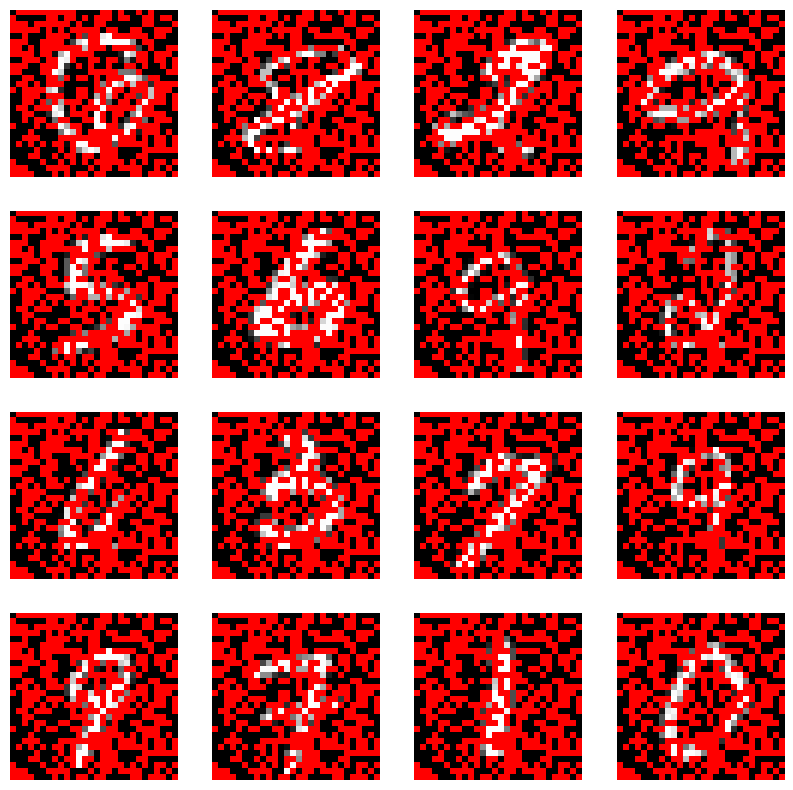

Iteration 0, loss = 2.5301
Checking accuracy on the val set
Got 8698 / 10000 correct (86.98%)
Iteration 0, loss = 0.6385
Checking accuracy on the val set
Got 8916 / 10000 correct (89.16%)
Iteration 0, loss = 0.4459
Checking accuracy on the val set
Got 8994 / 10000 correct (89.94%)
Iteration 0, loss = 0.3410
Checking accuracy on the val set
Got 9052 / 10000 correct (90.52%)
Iteration 0, loss = 0.5150
Checking accuracy on the val set
Got 9101 / 10000 correct (91.01%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.0000,  0.0000, -1.9949, -0.0000, -0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1996, -0.0000, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

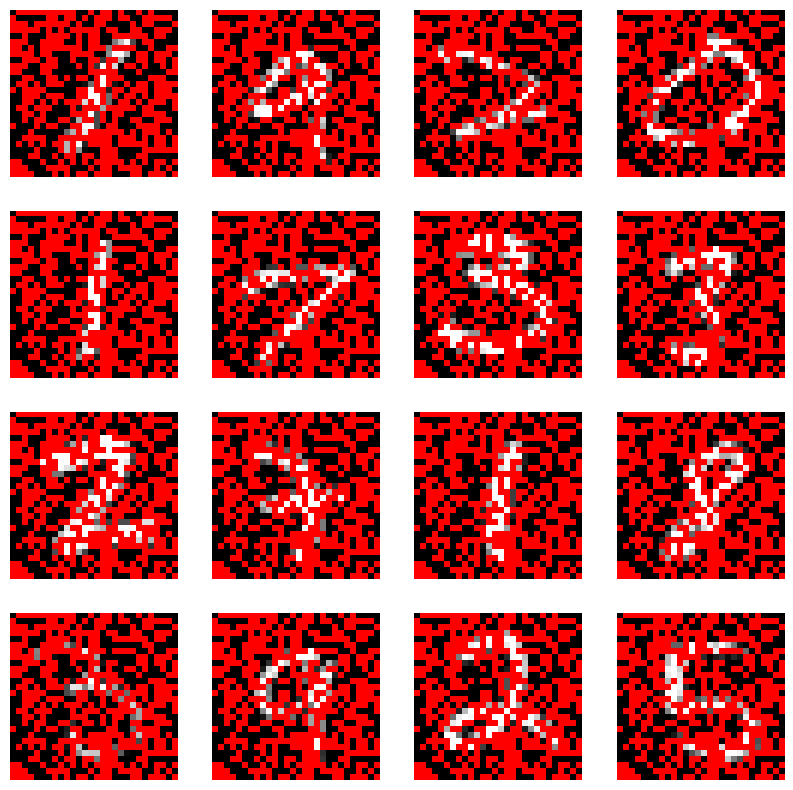

Iteration 0, loss = 2.4771
Checking accuracy on the val set
Got 8698 / 10000 correct (86.98%)
Iteration 0, loss = 0.4405
Checking accuracy on the val set
Got 8890 / 10000 correct (88.90%)
Iteration 0, loss = 0.4774
Checking accuracy on the val set
Got 8974 / 10000 correct (89.74%)
Iteration 0, loss = 0.3090
Checking accuracy on the val set
Got 9036 / 10000 correct (90.36%)
Iteration 0, loss = 0.3517
Checking accuracy on the val set
Got 9084 / 10000 correct (90.84%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.0000,  0.0000, -1.9948,  0.0000,  0.0000, -2.1372,
          0.0000, -3.2380,  1.3948, -3.1997, -0.0000, -1.9200,  1.3258,  1.2305,
          1.0768,  2.3710,  0.0000, -1.5556,

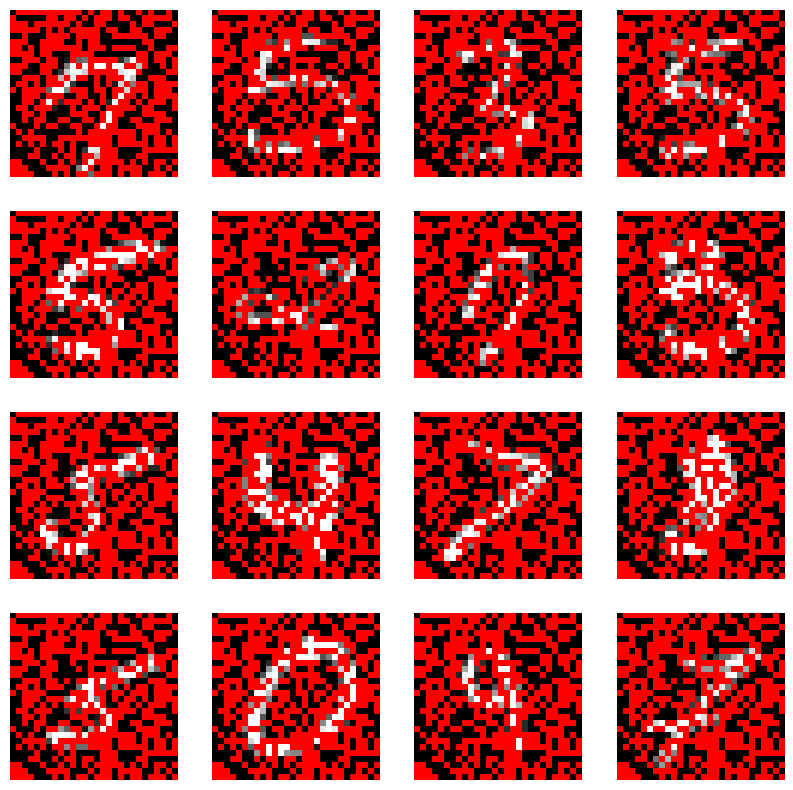

Iteration 0, loss = 2.4838
Checking accuracy on the val set
Got 8704 / 10000 correct (87.04%)
Iteration 0, loss = 0.5620
Checking accuracy on the val set
Got 8914 / 10000 correct (89.14%)
Iteration 0, loss = 0.3807
Checking accuracy on the val set
Got 9000 / 10000 correct (90.00%)
Iteration 0, loss = 0.3368
Checking accuracy on the val set
Got 9046 / 10000 correct (90.46%)
Iteration 0, loss = 0.2140
Checking accuracy on the val set
Got 9097 / 10000 correct (90.97%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -1.0856, -0.0000, -0.0000,
          2.3805, -0.0000,  0.0000,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2380,  1.3947, -3.1996, -0.0000, -1.9200,  1.3258,  1.2305,
          0.0000,  2.3710,  0.0000, -1.5556,

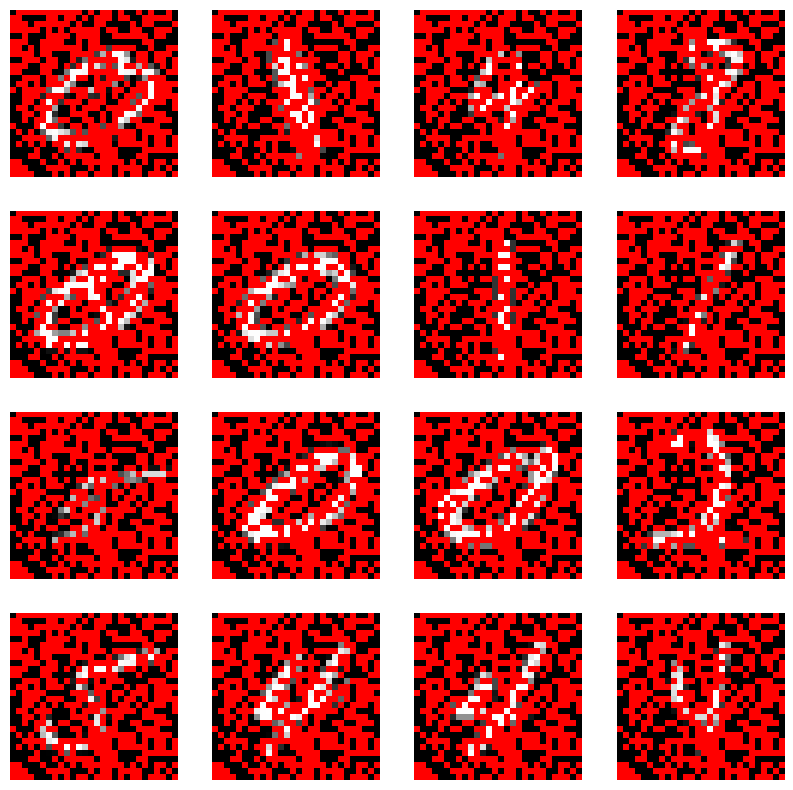

Iteration 0, loss = 2.4625
Checking accuracy on the val set
Got 8687 / 10000 correct (86.87%)
Iteration 0, loss = 0.4899
Checking accuracy on the val set
Got 8908 / 10000 correct (89.08%)
Iteration 0, loss = 0.3315
Checking accuracy on the val set
Got 8961 / 10000 correct (89.61%)
Iteration 0, loss = 0.3814
Checking accuracy on the val set
Got 9046 / 10000 correct (90.46%)
Iteration 0, loss = 0.2406
Checking accuracy on the val set
Got 9088 / 10000 correct (90.88%)
tensor([[ 1.2096,  0.0000,  0.0000, -0.0000,  2.9463,  0.0000,  0.0000,  0.0000,
         -1.2678, -0.0000,  0.0000,  2.7813,  2.4331, -0.0000, -2.1990,  2.0014,
          1.7946, -2.1707, -1.6907,  0.0000,  1.6522,  2.5963,  2.7248,  1.1172,
          3.6707,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
          2.3805, -0.0000,  0.0000,  0.0000, -1.9949, -0.0000,  0.0000, -2.1373,
          0.0000, -3.2379,  1.3947, -3.1996, -0.0000, -1.9200,  1.3258,  1.2305,
          0.0000,  2.3710, -0.0000, -1.5556,

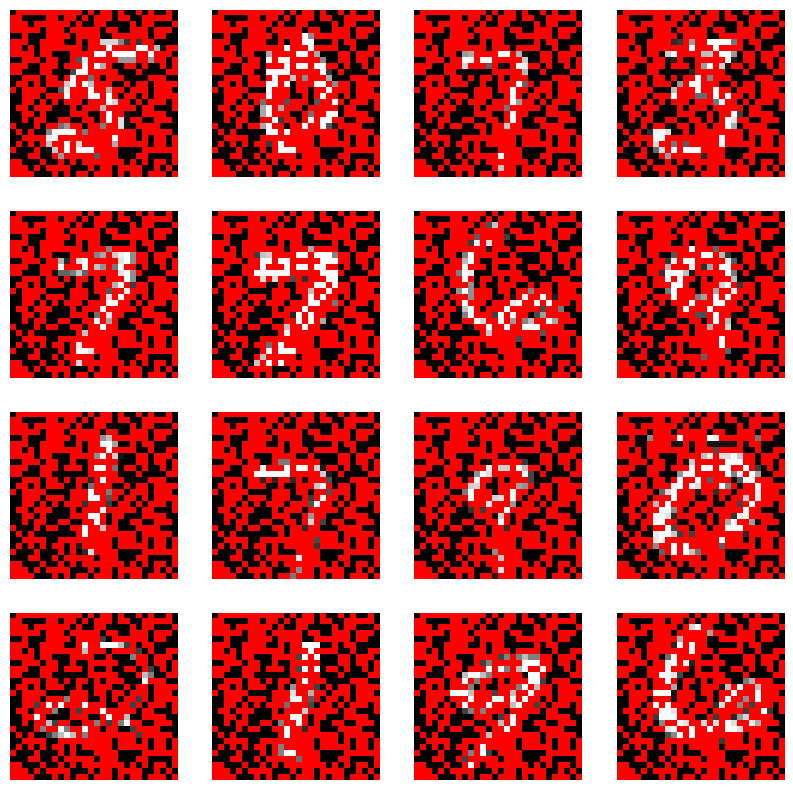

In [54]:
hidden_layer_size = 20
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))
mult = random_weight((1, 28 * 28))


# mult = torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True)

initial_w1 = w1.clone().detach().requires_grad_(False)
initial_w2 = w2.clone().detach().requires_grad_(False)
initial_mult = mult.clone().detach().requires_grad_(False)

m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)
m3 = torch.ones((28 * 28), dtype=dtype)

mask_overtime = []
graph_info = []
tot_pruned = 0
    
for k in range(30):
    for j in range(5):
        acc = train(two_layer_fc, [w1, w2, mult, m1, m2, m3], learning_rate, print_every=20000)

    
    # prune feature weights
    temp = []
    for i in range(28 * 28):
        if (m3[i] == 1):
            temp.append(abs(mult[0][i].item()))

    temp = list(sorted(temp))
    thres = temp[int(0.03 * len(temp))]

    for i in range(28 * 28):
        if abs(mult[0][i].item()) < thres and m3[i] == 1:
            m3[i] = 0
            tot_pruned += 1
            
    print(mult)
    mult = initial_mult.clone().detach().requires_grad_(True)
    
    print('-' * 128)
    print(k+1, "iteration of pruning done", "Remaining Features:", 100 - tot_pruned / (28 * 28) * 100, "%")
    print('-' * 128)
    
    images, labels = next(iter(loader_train))

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        
        to_pil = T.ToPILImage()
        pil_image = to_pil(images[i])

        
        rgb_image = pil_image.convert("RGB")
        
        for i in range(rgb_image.size[0]):
            for j in range(rgb_image.size[1]):
                if m3[i * 28 + j].item() == 0:
                    rgb_image.putpixel((i, j), (255, 0, 0))
        
        ax.imshow(rgb_image)
        
        ax.axis('off')

    plt.show()
    
    # Reset the weights
    w1 = initial_w1.clone().detach().requires_grad_(True)
    w2 = initial_w2.clone().detach().requires_grad_(True)
    
    graph_info.append((100 - tot_pruned / (28 * 28) * 100, acc))
    mask_overtime.append(m3.clone().detach().requires_grad_(False))



In [57]:
print(graph_info)

[(97.06632653061224, 0.9143), (94.26020408163265, 0.9158), (91.45408163265306, 0.9151), (88.77551020408163, 0.913), (86.22448979591837, 0.915), (83.6734693877551, 0.9131), (81.25, 0.9145), (78.8265306122449, 0.913), (76.53061224489795, 0.9142), (74.23469387755102, 0.914), (72.06632653061224, 0.9129), (70.02551020408163, 0.9163), (67.98469387755102, 0.9148), (66.07142857142857, 0.9147), (64.15816326530611, 0.9149), (62.244897959183675, 0.9156), (60.45918367346938, 0.9118), (58.6734693877551, 0.9131), (57.015306122448976, 0.9133), (55.357142857142854, 0.9112), (53.69897959183674, 0.9086), (52.16836734693878, 0.9138), (50.63775510204081, 0.9112), (49.23469387755102, 0.9105), (47.83163265306123, 0.9104), (46.42857142857143, 0.9092), (45.1530612244898, 0.9101), (43.87755102040817, 0.9084), (42.60204081632652, 0.9097), (41.326530612244895, 0.9088)]


In [59]:
w1 = initial_w1.clone().detach().requires_grad_(True)
w2 = initial_w2.clone().detach().requires_grad_(True)


no_feature_selection = train(two_layer_fc, 
                             [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, torch.ones((28 * 28), dtype=dtype)], 
                             learning_rate, print_every=100, verbose=True)

no_feature_selection = train(two_layer_fc, 
                             [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, torch.ones((28 * 28), dtype=dtype)], 
                             learning_rate, print_every=100, verbose=True)

no_feature_selection = train(two_layer_fc, 
                             [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, torch.ones((28 * 28), dtype=dtype)], 
                             learning_rate, print_every=100, verbose=True)

no_feature_selection = train(two_layer_fc, 
                             [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, torch.ones((28 * 28), dtype=dtype)], 
                             learning_rate, print_every=100, verbose=True)

no_feature_selection = train(two_layer_fc, 
                             [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, torch.ones((28 * 28), dtype=dtype)], 
                             learning_rate, print_every=100, verbose=True)

Iteration 0, loss = 2.4000
Iteration 100, loss = 1.6572
Iteration 200, loss = 1.3617
Iteration 300, loss = 0.9188
Iteration 400, loss = 0.7212
Iteration 500, loss = 0.5756
Iteration 600, loss = 0.5647
Iteration 700, loss = 0.6546
Checking accuracy on the val set
Got 8701 / 10000 correct (87.01%)
Iteration 0, loss = 0.6177
Iteration 100, loss = 0.4091
Iteration 200, loss = 0.5450
Iteration 300, loss = 0.6286
Iteration 400, loss = 0.5654
Iteration 500, loss = 0.4386
Iteration 600, loss = 0.5661
Iteration 700, loss = 0.4350
Checking accuracy on the val set
Got 8934 / 10000 correct (89.34%)
Iteration 0, loss = 0.4173
Iteration 100, loss = 0.2541
Iteration 200, loss = 0.2824
Iteration 300, loss = 0.4734
Iteration 400, loss = 0.3602
Iteration 500, loss = 0.3001
Iteration 600, loss = 0.3112
Iteration 700, loss = 0.3403
Checking accuracy on the val set
Got 9030 / 10000 correct (90.30%)
Iteration 0, loss = 0.2891
Iteration 100, loss = 0.3793
Iteration 200, loss = 0.3882
Iteration 300, loss = 0.

In [60]:
print(graph_info)

[(97.06632653061224, 0.9143), (94.26020408163265, 0.9158), (91.45408163265306, 0.9151), (88.77551020408163, 0.913), (86.22448979591837, 0.915), (83.6734693877551, 0.9131), (81.25, 0.9145), (78.8265306122449, 0.913), (76.53061224489795, 0.9142), (74.23469387755102, 0.914), (72.06632653061224, 0.9129), (70.02551020408163, 0.9163), (67.98469387755102, 0.9148), (66.07142857142857, 0.9147), (64.15816326530611, 0.9149), (62.244897959183675, 0.9156), (60.45918367346938, 0.9118), (58.6734693877551, 0.9131), (57.015306122448976, 0.9133), (55.357142857142854, 0.9112), (53.69897959183674, 0.9086), (52.16836734693878, 0.9138), (50.63775510204081, 0.9112), (49.23469387755102, 0.9105), (47.83163265306123, 0.9104), (46.42857142857143, 0.9092), (45.1530612244898, 0.9101), (43.87755102040817, 0.9084), (42.60204081632652, 0.9097), (41.326530612244895, 0.9088)]


In [61]:
print(graph_info)

[(97.06632653061224, 0.9143), (94.26020408163265, 0.9158), (91.45408163265306, 0.9151), (88.77551020408163, 0.913), (86.22448979591837, 0.915), (83.6734693877551, 0.9131), (81.25, 0.9145), (78.8265306122449, 0.913), (76.53061224489795, 0.9142), (74.23469387755102, 0.914), (72.06632653061224, 0.9129), (70.02551020408163, 0.9163), (67.98469387755102, 0.9148), (66.07142857142857, 0.9147), (64.15816326530611, 0.9149), (62.244897959183675, 0.9156), (60.45918367346938, 0.9118), (58.6734693877551, 0.9131), (57.015306122448976, 0.9133), (55.357142857142854, 0.9112), (53.69897959183674, 0.9086), (52.16836734693878, 0.9138), (50.63775510204081, 0.9112), (49.23469387755102, 0.9105), (47.83163265306123, 0.9104), (46.42857142857143, 0.9092), (45.1530612244898, 0.9101), (43.87755102040817, 0.9084), (42.60204081632652, 0.9097), (41.326530612244895, 0.9088)]


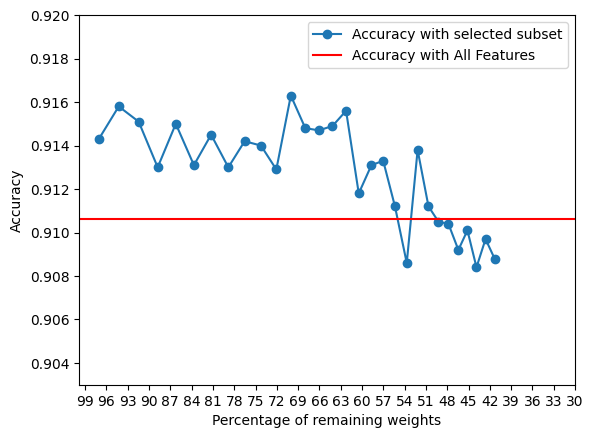

In [82]:
import matplotlib.pyplot as plt

x_values = [item[0] for item in graph_info]
y_values = [item[1] for item in graph_info]

# Plot "Accuracy with selected subset"
plt.plot(x_values, y_values, label="Accuracy with selected subset", marker='o')  # Added marker for clarity

# Reverse order of x-axis
plt.gca().invert_xaxis()

# Set x-axis to have fine-grained labels
plt.xticks(np.arange(30, 100, 3))


# Add labels to the axes
plt.xlabel('Percentage of remaining weights')
plt.ylabel('Accuracy')

# Draw horizontal line for "Accuracy with All Features"
plt.axhline(y=no_feature_selection, color='r', linestyle='-', label="Accuracy with All Features")

# Set y-axis limits to slightly beyond the min and max of y_values to ensure visibility
plt.ylim(0.903, 0.92)

# Add legend to help differentiate between lines
plt.legend()

# Show the plot
plt.show()


In [90]:
temp = []

for i in range(len(graph_info)):
    x = graph_info[i][0]
    
    n = int(x * 28 * 28 / 100
            )
    random_samples = np.random.choice(28 * 28, size=n, replace=False)
    
    m3 = torch.ones((28 * 28), dtype=dtype)
    
    for j in random_samples:
        m3[j] = 0
        
    w1 = initial_w1.clone().detach().requires_grad_(True)
    w2 = initial_w2.clone().detach().requires_grad_(True)
        
    cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
                             learning_rate, print_every=100, verbose=True)
    
    cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
                             learning_rate, print_every=100, verbose=True)
    
    cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
                             learning_rate, print_every=100, verbose=True)
    
    cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
                             learning_rate, print_every=100, verbose=True)
    
    cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
                             learning_rate, print_every=100, verbose=True)
    
    temp.append(cur)

Iteration 0, loss = 2.3271
Iteration 100, loss = 2.2656
Iteration 200, loss = 2.2437
Iteration 300, loss = 2.2070
Iteration 400, loss = 2.2072
Iteration 500, loss = 2.2135
Iteration 600, loss = 2.0893
Iteration 700, loss = 2.0937
Checking accuracy on the val set
Got 3603 / 10000 correct (36.03%)
Iteration 0, loss = 2.0970
Iteration 100, loss = 2.0580
Iteration 200, loss = 2.0801
Iteration 300, loss = 1.9758
Iteration 400, loss = 1.8923
Iteration 500, loss = 1.8537
Iteration 600, loss = 2.0161
Iteration 700, loss = 1.8859
Checking accuracy on the val set
Got 4233 / 10000 correct (42.33%)
Iteration 0, loss = 1.9211
Iteration 100, loss = 1.7998
Iteration 200, loss = 1.9116
Iteration 300, loss = 1.8965
Iteration 400, loss = 1.9265
Iteration 500, loss = 1.7738
Iteration 600, loss = 1.5859
Iteration 700, loss = 1.6708
Checking accuracy on the val set
Got 4683 / 10000 correct (46.83%)
Iteration 0, loss = 1.7840
Iteration 100, loss = 1.6606
Iteration 200, loss = 1.6421
Iteration 300, loss = 1.

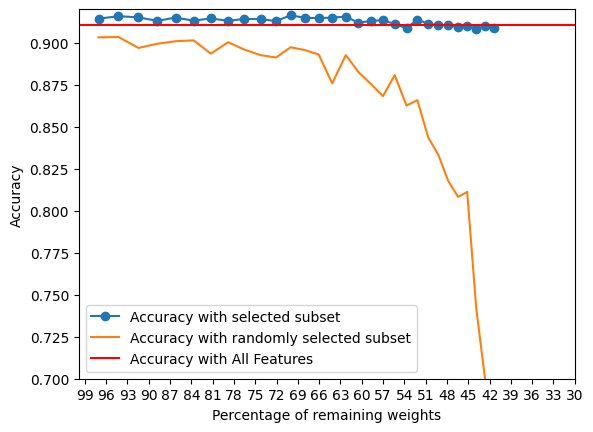

In [98]:
import matplotlib.pyplot as plt

x_values = [item[0] for item in graph_info]
y_values = [item[1] for item in graph_info]

# Plot "Accuracy with selected subset"
plt.plot(x_values, y_values, label="Accuracy with selected subset", marker='o')  # Added marker for clarity
plt.plot(x_values, list(reversed(temp)), label = "Accuracy with randomly selected subset")

# Reverse order of x-axis
plt.gca().invert_xaxis()

# Set x-axis to have fine-grained labels
plt.xticks(np.arange(30, 100, 3))

plt.xlabel('Percentage of remaining weights')
plt.ylabel('Accuracy')

# Draw horizontal line for "Accuracy with All Features"
plt.axhline(y=no_feature_selection, color='r', linestyle='-', label="Accuracy with All Features")

# Set y-axis limits to slightly beyond the min and max of y_values to ensure visibility
plt.ylim(0.7, 0.92)

# Add legend to help differentiate between lines
plt.legend()

# Show the plot
plt.show()


In [ ]:

# print(train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True))

# initial_w1 = random_weight((28 * 28, hidden_layer_size))
# initial_w2 = random_weight((hidden_layer_size, 10))



In [ ]:
# initial_w1 = random_weight((28 * 28, hidden_layer_size))
# initial_w2 = random_weight((hidden_layer_size, 10))

# for i in range(len(graph_info)):
#     x = graph_info[i][0]
    
#     n = int(x * 28 * 28 / 100
#             )
#     random_samples = np.random.choice(28 * 28, size=n, replace=False)
    
#     m3 = torch.ones((28 * 28), dtype=dtype)
    
#     for j in random_samples:
#         m3[j] = 0
        
#     w1 = initial_w1.clone().detach().requires_grad_(True)
#     w2 = initial_w2.clone().detach().requires_grad_(True)
        
#     cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True)
    
#     cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True)
    
#     cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True)
    
#     cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True)
    
#     cur = train(two_layer_fc, [w1, w2, torch.ones((1, 28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], 
#                              learning_rate, print_every=100, verbose=True)
    
#     temp.append(cur)